In [23]:
%matplotlib inline

# import packages
import numpy as np
import time
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib import gridspec

import torch
from torch.nn import Linear, LeakyReLU, MSELoss, Sequential
from torch.optim import Adam

from kymatio import Scattering1D


In [24]:
# define plot properties
from cycler import cycler
import matplotlib.cm as cm

from matplotlib import rcParams
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable

def rgb(r,g,b):
    return (float(r)/256.,float(g)/256.,float(b)/256.)

cb2 = [rgb(31,120,180), rgb(255,127,0), rgb(51,160,44), rgb(227,26,28), \
       rgb(166,206,227), rgb(253,191,111), rgb(178,223,138), rgb(251,154,153)]

rcParams['figure.figsize'] = (9,7.5)
#rcParams['figure.dpi'] = 300

rcParams['lines.linewidth'] = 1

rcParams['axes.prop_cycle'] = cycler('color', cb2)
rcParams['axes.facecolor'] = 'white'
rcParams['axes.grid'] = False

rcParams['patch.facecolor'] = cb2[0]
rcParams['patch.edgecolor'] = 'white'

rcParams['font.size'] = 23


> Calculate scattering coefficients.

In [ ]:
# import packages
from kymatio import Scattering1D
import kymatio

import torch.nn as nn
import torch.optim
import torch
import torch.utils.data as utils

import time
import sys

import numpy as np


#=========================================================================================================
# load light curves
real_spec = np.load("../light_curve.npy")[:10,:]
print(real_spec.shape)

### change the amplitude
#real_spec = real_spec*2.

## mix two modes
#real_spec = (real_spec[:,:] + real_spec[::-1,:])/2.


#================================================================================================
# define wavelet scattering hyperparameters
J = 6
Q = 8
T = real_spec.shape[1]

# convert into torch variable
x = torch.from_numpy(real_spec[:,:T]).type(torch.FloatTensor)
print(x.shape)

# define wavelet scattering
scattering = Scattering1D(J, T, Q)

#================================================================================================
# perform wavelet scattering
Sx_all = scattering.forward(x)

# calculate invariate representation
Sx_all = torch.mean(Sx_all, dim=-1)

# normalize wrt to the first coefficient
for i in range(Sx_all.shape[0]):
    Sx_all[i,:] = Sx_all[i,:]/np.abs(Sx_all[i,0])
    
# take log to normalize the coefficient better
Sx_all = torch.log10(Sx_all[:,1:])
print(Sx_all.shape)

In [ ]:
Sx_all_1 = np.copy(Sx_all)

In [ ]:
Sx_all = Sx_all.numpy()

In [ ]:
print(Sx_all_1[0,:])
plt.plot(Sx_all_1[0,:])
plt.plot(Sx_all[0,:])

> Check wavelet scattering coefficients.

In [ ]:
# load scattering coefficients
Sx = np.load("../Sx_all.npy")
plt.hist(Sx.ravel(), bins=100);

> Visualize first order WST coefficients as a proxy for power spectrum.

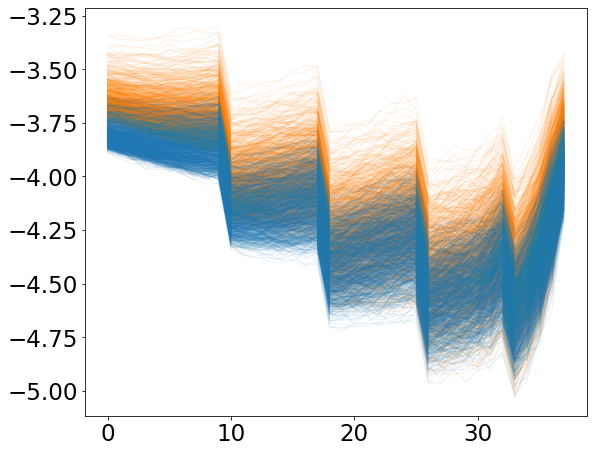

In [48]:
Sx_coefficient = np.load("../Sx_all_normal_order=1.npy").T
plt.plot(Sx_coefficient, color=cb2[1], alpha=0.1);

Sx_coefficient = np.load("../Sx_all_mixed_order=1.npy").T
plt.plot(Sx_coefficient, color=cb2[0], alpha=0.1);

> Sample log probablity.

In [35]:
# import packages
import numpy as np
from astropy.io import fits
import os

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter
from torch.autograd import Variable

os.environ['KMP_DUPLICATE_LIB_OK']='True'


#========================================================================================================
# read scattering coefficents
y_tr = np.load("../Sx_all_validation_order=1.npy")

# read GP coefficients
# y_tr = np.load("../kernel_param_mock_mixed_dt=0.001.npy")

# restore Lomb Scargle coefficients
# temp = np.load("../g_lomb_scargle_mixed.npz")
# y_tr = temp["power_added"]

# convert into torch
y_tr = torch.from_numpy(y_tr).type(torch.FloatTensor)


#=======================================================================================================
# In [2]:
# define normalizing flow
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()

        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])

    def g(self, z):
        x = z
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1-self.mask[i])
            t = self.t[i](z_) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J

    def log_prob(self,x):
        z, logp = self.f(x)
        return self.prior.log_prob(z) + logp

    def sample(self, z):
        x = self.g(z)
        return x
    
    
#==================================================================================
# restore models
flow = torch.load("../flow_final_wst_order=1.pt", map_location=lambda storage, loc: storage) # load in cpu
flow.eval()

#-------------------------------------------------------------------------------------------------------
# sample results
log_prob_x = flow.log_prob(y_tr).detach().numpy()

# save results
np.savez("../real_nvp_results_light_curve_validation_order=1.npz",\
         log_prob_x = log_prob_x)

print(log_prob_x)

[91.19491  94.091995 83.18386  85.694664 82.14912  86.8983   81.03339
 82.04837  70.570145 87.015564 79.786865 88.43672  87.81172  93.21024
 75.55521  91.42044  77.60397  84.65467  83.44016  84.40744  91.354324
 77.00455  89.01841  84.7455   80.38911  70.88538  93.51345  81.08316
 91.31123  92.53864  81.09406  80.020615 88.68295  69.4708   74.705536
 81.38484  83.60454  84.16458  94.12302  91.45237  88.20964  80.039856
 76.221985 84.04499  89.97259  78.1087   71.0566   86.63422  79.42034
 88.655876 84.76482  81.43672  73.804214 83.40196  62.809464 83.815544
 78.7648   72.360565 70.96687  61.19709  90.41368  87.27057  80.04398
 73.242065 77.3677   93.80472  82.795    76.84898  85.941864 91.671875
 80.90761  93.312225 72.23302  76.56989  81.5719   95.529236 88.26792
 91.619835 91.99757  89.60699  76.65853  63.424957 87.17854  97.50861
 84.49036  94.53281  84.97402  75.313385 83.44032  85.11401  78.477005
 90.71182  83.16078  88.29582  88.89912  91.57904  75.822426 77.72447
 91.49437  78.

 /Users/yting/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning:
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
 /Users/yting/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning:
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
 /Users/yting/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning:
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


Text(0, 0.5, '# light curves')

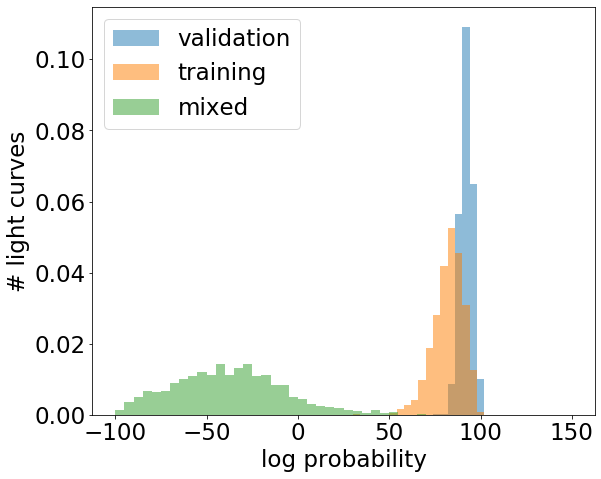

In [39]:
temp = np.load("../real_nvp_results_light_curve_normal_order=1.npz")
plt.hist(temp["log_prob_x"], bins=50, label="validation", alpha=0.5, range=[-50,150], normed=True);

temp = np.load("../real_nvp_results_light_curve_validation_order=1.npz")
plt.hist(temp["log_prob_x"], bins=50, label="training", alpha=0.5, range=[-50,150], normed=True);

temp = np.load("../real_nvp_results_light_curve_mixed_order=1.npz")
plt.hist(temp["log_prob_x"], bins=50, label="mixed", alpha=0.5, range=[-100,150], normed=True);

plt.legend()

plt.xlabel("log probability")
plt.ylabel("# light curves")

## Gaussian Processes inputation.

> Run with GPy. First a simple example.


In [ ]:
import numpy as np
import GPy

# make mock data
X = np.random.uniform(-3.,3.,(20,1))
Y = np.sin(X) + np.random.randn(20,1)*0.05

# define kernel
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
m = GPy.models.GPRegression(X,Y,kernel)

# optimize
m.optimize(messages=True)
m.optimize_restarts(num_restarts = 10)

# display results
fig = m.plot(plot_density=True)
GPy.plotting.show(fig, filename='basic_gp_regression_density_notebook_optimized')

> Make prediction with the models.

In [ ]:
plt.scatter(X,Y)

X_array = np.linspace(-4,4,100)
X_array = X_array.reshape(X_array.size,1)

Y_predict = np.array(m.predict(X_array))[0,:,:]
plt.plot(X_array,Y_predict)

> Try with real light curve.

In [ ]:
import GPy

# load light curve
temp = np.load("../light_curve.npz")
light_curve = temp["light_curve"]
t_array = temp["t_array"]

# extract a single light cure
X = t_array[0,:]
X = X.reshape(X.size,-1)
Y = light_curve[0,:]
Y = Y.reshape(Y.size,-1)

# define kernel
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
m = GPy.models.GPRegression(X[::10],Y[::10],kernel)

# optimize
m.optimize(messages=True)
m.optimize_restarts(num_restarts = 10)

# display results
fig = m.plot(plot_density=True)
GPy.plotting.show(fig, filename='basic_gp_regression_density_notebook_optimized')

In [ ]:
plt.plot(t_array[0,:],light_curve[0,:], color=cb2[1])

X_array = t_array[0,:]
X_array = X_array.reshape(X_array.size,1)

Y_predict = np.array(m.predict(X_array))[0,:,0]
Y_std = np.sqrt(np.array(m.predict(X_array))[1,:,0])

plt.plot(X_array[:,0],Y_predict, color="black")
plt.fill_between(X_array[:,0], Y_predict-Y_std, Y_predict+Y_std, color=cb2[0])

## SDSS DR14 QSO.

> Read data files.


In [ ]:
## all flies
import os
list_files = os.listdir("../qso")

# initiate array
mjd_g = []
g_array = []
mjd_r = []
r_array = []
list_files_store = []

#-------------------------------------------------------------------------------------
# loop over all files
for i in range(len(list_files)):
        
    try:
        # read data
        data = np.loadtxt("../qso/" + list_files[i])
        mjd_g_temp = data[:,2]
        g_temp = data[:,3]
        mjd_r_temp = data[:,0]
        r_temp = data[:,1]
    
        # cull empty entries and sort by time
        choose = mjd_g_temp > 10.
        mjd_g_temp = mjd_g_temp[choose]
        g_temp = g_temp[choose]
        choose = np.argsort(mjd_g_temp)
        mjd_g_temp = mjd_g_temp[choose]
        g_temp = g_temp[choose]
    
        choose = mjd_r_temp > 10.
        mjd_r_temp = mjd_r_temp[choose]
        r_temp = r_temp[choose]
        choose = np.argsort(mjd_r_temp)
        mjd_r_temp = mjd_r_temp[choose]
        r_temp = r_temp[choose]

        # record results
        mjd_g.append(mjd_g_temp)
        g_array.append(g_temp)
        mjd_r.append(mjd_r_temp)
        r_array.append(r_temp)
        list_files_store.append(list_files[i])
        
    except:
        print(i)

# convert to numpy array
mjd_g = np.array(mjd_g)
g_array = np.array(g_array)
mjd_r = np.array(mjd_r)
r_array = np.array(r_array)
list_files = np.array(list_files_store)

#-------------------------------------------------------------------------------------
# save results
np.savez("../SDSS_DR14_qso.npz",\
         mjd_g = mjd_g,\
         g_array = g_array,\
         mjd_r = mjd_r,\
         r_array = r_array,\
         list_files = list_files)


> Investigate the time stamp range.

In [ ]:
# time step range
mjd_g_range = np.array([mjd_g[i][-1]-mjd_g[i][0] for i in range(mjd_g.size)])
mjd_r_range = np.array([mjd_r[i][-1]-mjd_r[i][0] for i in range(mjd_g.size)])

plt.hist(mjd_g_range, bins=100, range=[400,500]);
plt.hist(mjd_r_range, bins=100, range=[400,500]);


In [ ]:
# time step recorded
mjd_g_range = np.array([len(mjd_g[i]) for i in range(mjd_g.size)])
mjd_r_range = np.array([len(mjd_r[i]) for i in range(mjd_g.size)])

plt.hist(mjd_g_range, bins=100);
plt.hist(mjd_r_range, bins=100);

#print(np.where(mjd_g_range > 200))

> Try Gaussian Processes on light curve.

Optimization restart 1/10, f = -70.9027613571524
Optimization restart 2/10, f = 141.89385332047186
Optimization restart 3/10, f = -70.90276135748456
Optimization restart 4/10, f = 141.89385332046706
Optimization restart 5/10, f = 141.89385289824259
Optimization restart 6/10, f = 141.89385313956134
Optimization restart 7/10, f = -70.90276135750824
Optimization restart 8/10, f = 141.8938533204673
Optimization restart 9/10, f = -70.9027613574423
Optimization restart 10/10, f = -70.90276135751805
  Mat32.       |               value  |  constraints  |  priors
  variance     |  1.1333824420562153  |      +ve      |        
  lengthscale  |   131.3569666721917  |      +ve      |        


AttributeError: 'dict' object has no attribute 'figure'

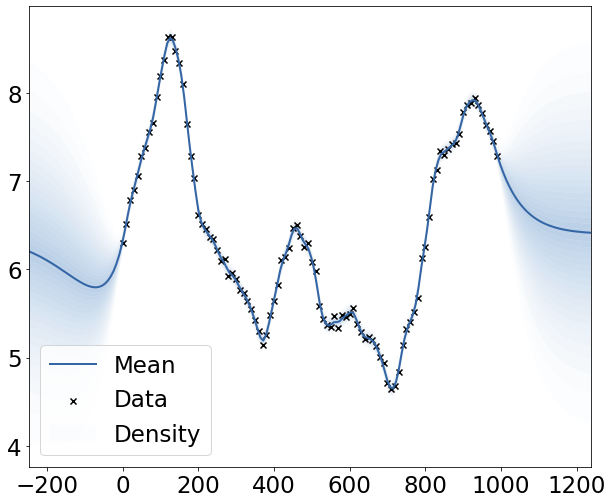

In [40]:
import GPy
import numpy as np


#==================================================================================
### restore mock grid ###
temp = np.load("../SDSS_DR14_qso_mock_normal_dense.npz", allow_pickle=True)
mjd_g = temp["t_array"][:,::100]
g_array = temp["light_curve"][:,::100]


#==================================================================================
# choose one object
ind_choose = 0

# extract a single light cure
X = (mjd_g[ind_choose] - mjd_g[ind_choose][0])
X = X.reshape(X.size,-1)
Y = g_array[ind_choose]
Y = Y.reshape(Y.size,-1)

# define kernel
k0 = GPy.kern.Matern32(1) 
k1 = GPy.kern.Matern32(1) 
k2 = GPy.kern.Matern32(1) 

#kernel = k0 + k1 + k2 
kernel = k0 
m = GPy.models.GPRegression(X, Y, kernel, normalizer=True)
#print(m.kern)

#-------------------------------------------------------------------------------------
# set range parameters
# m.kern.Mat32.lengthscale.constrain_bounded(0.1,1)
# m.kern.Mat32.variance.constrain_bounded(1e-10,1e-5)

# m.kern.Mat32_1.lengthscale.constrain_bounded(1,10)
# m.kern.Mat32_1.variance.constrain_bounded(1e-10,1e-5)

# m.kern.Mat32_2.lengthscale.constrain_bounded(10,100)
# m.kern.Mat32_2.variance.constrain_bounded(1e-10,1.)

# Fix the noise variance to known value 
#m.Gaussian_noise.variance = 1e-3**2
#m.Gaussian_noise.variance.fix()

# optimize
m.optimize(messages=True)
m.optimize_restarts(num_restarts = 10)
print(m.kern)

#-------------------------------------------------------------------------------------
# extract parameters
# lengthscale_array = np.array([m.kern.Mat32.lengthscale[0],\
#                          m.kern.Mat32_1.lengthscale[0],\
#                          m.kern.Mat32_2.lengthscale[0]])
# variance_array = np.array([m.kern.Mat32.variance[0],\
#                          m.kern.Mat32_1.variance[0],\
#                          m.kern.Mat32_2.variance[0]])

# # sort by lengthscale
# length_sort = np.argsort(lengthscale_array)
# lengthscale_array = lengthscale_array[length_sort]
# variance_array = variance_array[length_sort]

# # combine all parameters
# kernel_param = np.concatenate([lengthscale_array,variance_array])
# print(kernel_param)

### assuming just one kernel
kernel_param = np.concatenate([m.kern.lengthscale,m.kern.variance])

#-------------------------------------------------------------------------------------
# display results
fig = m.plot(plot_density=True)
GPy.plotting.show(fig, filename='basic_gp_regression_density_notebook_optimized')

In [ ]:
# set grid to interpolate into
X_array = np.arange(5120)*0.1
X_array = X_array.reshape(X_array.size,1)

# make prediction
Y_predict = np.array(m.predict(X_array))[0,:,0]
Y_std = np.sqrt(np.array(m.predict(X_array))[1,:,0])

# original data
plt.scatter(X.ravel(), Y.ravel(), color=cb2[1])

# prediction
plt.plot(X_array[:,0],Y_predict, color="black")
plt.fill_between(X_array[:,0], Y_predict-Y_std, Y_predict+Y_std, color=cb2[0], alpha=0.5)

> Check time step gaps.

In [ ]:
# restore grid
temp = np.load("../SDSS_DR14_qso.npz", allow_pickle=True)
mjd_g = temp["mjd_g"]
mjd_gap = []
for i in range(mjd_g.size):
    mjd_gap.extend(mjd_g[i][1:]-mjd_g[i][:-1])
mjd_gap = np.array(mjd_gap)
print(mjd_gap.size)
plt.hist(mjd_gap, bins=100, range=[0,0.01])

> Gaussian Processes in batch.

In [ ]:
# Gaussian Processes package
import GPy
import time
from multiprocessing import Pool
import os
import numpy as np

# set number of threads per CPU
os.environ['OMP_NUM_THREADS']='{:d}'.format(1)

#-------------------------------------------------------------------------------------
# restore grid
# temp = np.load("../SDSS_DR14_qso.npz", allow_pickle=True)
# mjd_g = temp["mjd_g"]
# g_array = temp["g_array"]

### restore mock grid ###
temp = np.load("../SDSS_DR14_qso_mock.npz", allow_pickle=True)
mjd_g = temp["t_array"]
g_array = temp["light_curve"]

# set grid to interpolate into
# X_array = np.arange(5120)*0.1
# X_array = X_array.reshape(X_array.size,1)

#-------------------------------------------------------------------------------------
# interpolate with GP
def GP_interp(ind_choose):

    # extract a single light cure
    X = (mjd_g[ind_choose] - mjd_g[ind_choose][0])
    X = X.reshape(X.size,-1)
    Y = g_array[ind_choose]
    Y = Y.reshape(Y.size,-1)

    # define kernel
    k0 = GPy.kern.Matern32(1) 
    k1 = GPy.kern.Matern32(1) 
    k2 = GPy.kern.Matern32(1) 
    kernel = k0 + k1 + k2 
    
#-------------------------------------------------------------------------------------
    # define regression
    m = GPy.models.GPRegression(X, Y, kernel, normalizer=True)

    # set range parameters
#     m.kern.Mat32.lengthscale.constrain_bounded(0.1,1)
#     m.kern.Mat32.variance.constrain_bounded(1e-10,1e-5)

#     m.kern.Mat32_1.lengthscale.constrain_bounded(1,10)
#     m.kern.Mat32_1.variance.constrain_bounded(1e-10,1e-5)

#     m.kern.Mat32_2.lengthscale.constrain_bounded(10,100)
#     m.kern.Mat32_2.variance.constrain_bounded(1e-10,1.)

    # fix the noise variance to known value 
#     m.Gaussian_noise.variance = 1e-2**2
#     m.Gaussian_noise.variance.fix()

#-------------------------------------------------------------------------------------
    # optimize
    m.optimize(messages=True)
    m.optimize_restarts(num_restarts = 10)

    # make prediction
    #Y_predict = np.array(m.predict(X_array))[0,:,0]
    
#-------------------------------------------------------------------------------------
    # extract parameters
    lengthscale_array = np.array([m.kern.Mat32.lengthscale[0],\
                                  m.kern.Mat32_1.lengthscale[0],\
                                  m.kern.Mat32_2.lengthscale[0]])
    variance_array = np.array([m.kern.Mat32.variance[0],\
                               m.kern.Mat32_1.variance[0],\
                               m.kern.Mat32_2.variance[0]])

    # sort by lengthscale
    length_sort = np.argsort(lengthscale_array)
    lengthscale_array = lengthscale_array[length_sort]
    variance_array = variance_array[length_sort]

    # combine all parameters
    Y_predict = np.concatenate([lengthscale_array,variance_array])

#-------------------------------------------------------------------------------------
    # return prediction
    return Y_predict


#=====================================================================================
# number of CPU to run in parallel
num_CPU = 4
pool = Pool(num_CPU)
start_time = time.time()
Y_predict_array = np.array(pool.map(GP_interp,range(mjd_g.size)))
print(time.time()-start_time)
    
# save results
np.save("../kernel_param_mock.npy", np.array(Y_predict_array))


> Plot kernel parameter distribution.

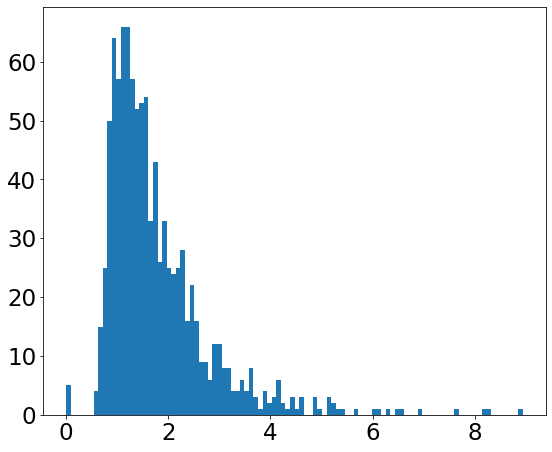

In [12]:
kernel_param = np.load("../kernel_param_mock.npy")
plt.hist(kernel_param[:,5],bins=100);

> Plot training loss.

In [ ]:
temp = np.load("../loss_results.npz")
plt.plot(temp["loss_array"])
plt.ylim([-500,0])

## Lomb Sargles as representations.

> Using Lomb Scargles as a metric.

Cannot use the interpolated version, because the Gaussian kernel period will imprint on it.

In [4]:
from astropy.timeseries import LombScargle
from scipy import interpolate

# choose a frequency grid to interpolate into
frequency_interp = np.arange(1201)/1200.*0.6


#====================================================================================
# restore grid
#temp = np.load("../SDSS_DR14_qso.npz", allow_pickle=True)
#mjd_g = temp["mjd_g"]
#g_array = temp["g_array"]

temp = np.load("../SDSS_DR14_qso_mock_normal_dense.npz", allow_pickle=True)
mjd_g = temp["t_array"]
g_array = temp["light_curve"]


#====================================================================================
# initiate result arrays
power_array = []

# loop over all objects
for i in range(g_array.shape[0]):
    if i % 100 == 0:
        print(i)
        
    frequency, power = LombScargle(mjd_g[i], g_array[i]).autopower(method='fast')
    #frequency, power = LombScargle(mjd_g[i], g_array[i]).autopower(method='slow')
    
    f_power = interpolate.interp1d(frequency, power, bounds_error=False, fill_value=0.)
    power_array.append(f_power(frequency_interp))

#-------------------------------------------------------------------------------------
# convert to numpy array
power_array = np.array(power_array)

# sum up power
power_added = np.zeros((power_array.shape[0],12))
for j in range(power_array.shape[0]):
    for i in range(12):
        power_added[j,i] = np.sum(power_array[j,i*100:(i+1)*100])
        
# save results
np.savez("../g_lomb_scargle_normal_dense.npz",\
         frequency_interp = frequency_interp,\
         power_array = power_array,\
         power_added = power_added)


0
100
200
300
400
500
600
700
800
900


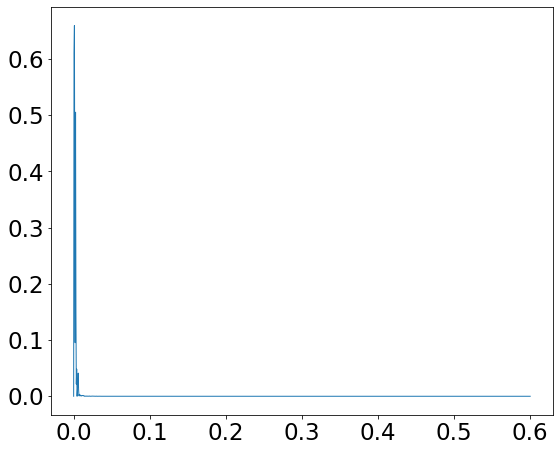

In [7]:
temp = np.load("../g_lomb_scargle_normal_dense.npz")
frequency_interp = temp["frequency_interp"]
power_array = temp["power_array"]
power_added = temp["power_added"]

plt.plot(frequency_interp, power_array[0,:])
#plt.plot(frequency_interp[::100][:-1], power_added[0,:])
#for i in range(1000):
#    plt.plot(frequency_interp[::100][:-1], power_added[i,:], color=cb2[0], alpha=0.01)

#------------------------------------------------------------------------------------------
# temp = np.load("../g_lomb_scargle_validation.npz")
# frequency_interp = temp["frequency_interp"]
# power_array = temp["power_array"]
# power_added = temp["power_added"]

# for i in range(1000):
#     plt.plot(frequency_interp[::100][:-1], power_added[i,:], color=cb2[1], alpha=0.1)


> Check mock SDSS qso.

In [ ]:
# restore grid
temp = np.load("../SDSS_DR14_qso_mock.npz", allow_pickle=True)
mjd_g = temp["t_array"]
g_array = temp["light_curve"]

ind_choose = 90
print(mjd_g[ind_choose].size)
plt.scatter(mjd_g[ind_choose],g_array[ind_choose])